# plaq-u-net: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022

This is a code supporting the corresponding paper.

Packages import:

In [2]:
import os
import numpy as np

from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pydicom
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches

import cv2
import SimpleITK as sitk

from skimage import exposure
from skimage import img_as_float
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pandas as pd

plt.style.use("ggplot")

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from scipy.ndimage import zoom

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'                        
import tensorflow as tf
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

W1013 13:55:46.393004 29376 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1013 13:55:46.395009 29376 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1013 13:55:46.397008 29376 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1013 13:55:50.833237 29376 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [21]:
import nibabel as nib
import pickle

## 1. Loading the models

Defining model blocks:

In [4]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def get_unet(input_img, n_filters = 8, dropout = 0.2, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Defining metrics:

In [5]:
def dice_coef(y_true, y_pred):
    from keras import backend as K
    smooth=1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def custom_loss(y_true, y_pred):
    from keras.losses import binary_crossentropy
    return 0.5*keras.losses.binary_crossentropy(y_true,y_pred)+0.5*dice_loss(y_true,y_pred)

Models compilation + loading weights:

In [8]:
im_height = 64
im_width = 64

input_img = Input((im_height, im_width, 2), name='img')

model_simple = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model_simple.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy', dice_coef])
model_simple.load_weights('../res/plaq-u-net_simple_dce.h5')

model_aug = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model_aug.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy', dice_coef])
model_aug.load_weights('../res/plaq-u-net_aug_dce.h5')

W1013 13:57:17.491328 29376 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W1013 13:57:19.431982 29376 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



Patching and consensus map calculation:

In [10]:
sub_names_test = ['AMC012', 'AMC006', 
                  'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038', 'MUMC093', 'MUMC107', 
                  'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 'MUMC059', 'MUMC080', 
                  'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [11]:
dirname_imgdata = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/imagesTr/'
dirname_imgdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/imagesTs1/'
dirname_gtdata = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/labelsTr/'
dirname_gtdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/labelsTs1/'
dirname_nnunetdata = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_results/Tr/'
dirname_nnunetdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_results/Ts1/'

In [14]:
n_samples_test = 0

for sub_name in sub_names_test:
    
    filename_img = dirname_imgdata_test + sub_name + '_0000.nii.gz'
    filename_sm = dirname_nnunetdata_test + sub_name + '.npz'
    filename_pkl = dirname_nnunetdata_test + sub_name + '.pkl'
    filename_gt = dirname_gtdata_test + sub_name + '.nii.gz'
    
    img = nib.load(filename_img).get_fdata().T
    n_samples_test += img.shape[0]
    
n_samples_test

350

In [15]:
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_SIDE = 64

In [16]:
def norm_img(img_arr):

    img_min = np.min(img_arr) 
    img_max = np.max(img_arr) 
    
    img_norm = np.copy((img_arr - img_min)/(img_max - img_min)*255).astype(np.uint8)
        
    return img_norm

In [29]:
def fill_arrays(X, y, sub_names, dirname_img, dirname_nnunet, dirname_gt):
    
    i = 0

    for sub_name in sub_names:
       

        filename_img = dirname_img + sub_name + '_0000.nii.gz'
        filename_sm = dirname_nnunet + sub_name + '.npz'
        filename_pkl = dirname_nnunet + sub_name + '.pkl'
        filename_gt = dirname_gt + sub_name + '.nii.gz'

        img = nib.load(filename_img).get_fdata().T
        gt = nib.load(filename_gt).get_fdata().T
        sm_cropped = np.load(filename_sm)['softmax']
        with open(filename_pkl, 'rb') as f:
            p = pickle.load(f)
        crop_box = p['crop_bbox']
        sm = np.zeros(img.shape, dtype=np.float16)
        sm[crop_box[0][0]:crop_box[0][1], crop_box[1][0]:crop_box[1][1], crop_box[2][0]:crop_box[2][1]] = sm_cropped[1, ...]

        for j in range (0, img.shape[0]):
            img_norm = norm_img(img[j, ...])
            X[i, ..., 0] = img_norm
            X[i, ..., 1] = sm[j, ...]
            y[i, ..., 0] = gt[j, ...]
            i += 1
                
    return None
    

In [30]:
X_test = np.zeros((n_samples_test, IMG_HEIGHT, IMG_WIDTH, 2), dtype = np.uint8)
y_test = np.zeros((n_samples_test, IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.uint8)

In [31]:
fill_arrays(X_test, y_test, sub_names_test, dirname_imgdata_test, dirname_nnunetdata_test, dirname_gtdata_test)

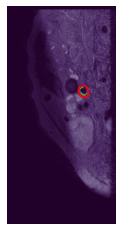

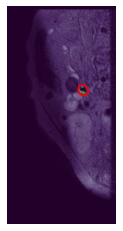

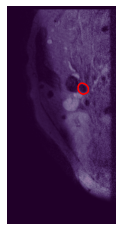

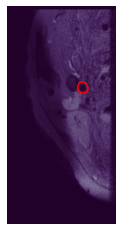

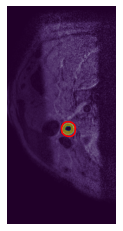

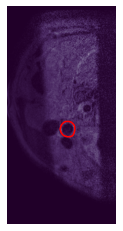

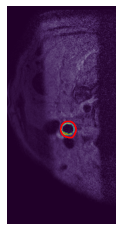

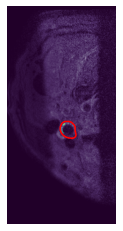

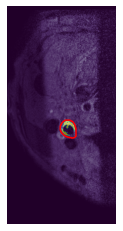

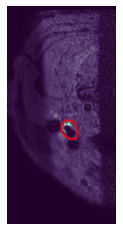

In [33]:
for i in range (145, 155):
    plt.imshow(X_test[i, ..., 0], cmap = 'bone')
    plt.imshow(X_test[i, ..., 1], alpha = 0.5)
    plt.contour(y_test[i, ..., 0], colors='r', levels=[0.5])
    plt.axis('Off')
    plt.show()

In [112]:
img_padded = np.zeros((IMG_HEIGHT+128, IMG_WIDTH+128, 2), dtype=np.uint8)
img_padded[64:-64, 64:-64, :] = X_test[2, ...]
    
sm = img_padded[..., 1]
sm_bin = (sm>0).astype(np.uint8)
sm_bin_label = label(sm_bin)
label_weights = []
for l in range(1, np.max(sm_bin_label)+1):
    mask_label = (sm_bin_label==l).astype(np.uint8)
    weight_label = np.sum(mask_label*sm)
    rec_lw = {'label': l, 'weight': weight_label}
    label_weights.append(rec_lw)
label_weights = pd.DataFrame(label_weights)
n_labels = min(len(label_weights), 1)
labels = []
if len(label_weights)>0:
    label_weights.sort_values(by='weight', inplace=True, ascending = False)
    labels = np.array(label_weights['label'])[:n_labels]
contour = np.isin(sm_bin_label, labels).astype(np.uint8)
contour_pixels = np.where(contour>0)
x_center = int(np.mean(contour_pixels[0]))
y_center = int(np.mean(contour_pixels[1]))
    
step = 32
x_kernels = []
y_kernels = []
n_kernels = 25
    
M = np.empty((img_padded.shape[0], img_padded.shape[1], n_kernels))
M[:] = np.NaN
img_patch = np.zeros((n_kernels, 64, 64, 2))
    
c = 0
    
for x in range(x_center-step, x_center+step+1, 16):
    for y in range(y_center-step, y_center+step+1, 16):
        img_crop = img_padded[x-step:x+step, y-step:y+step, :]
        img_patch[c, ...] = img_crop.copy()
        c += 1
            
img_patch_pred = model_aug.predict(img_patch, verbose=0)
    
c = 0
for x in range (x_center-step, x_center+step+1, 16):
    for y in range (y_center-step, y_center+step+1, 16):
        M[x-step:x+step, y-step:y+step, c] = img_patch_pred[c, ..., 0]
        c += 1
            
M_concord = np.nanmean(M, axis = 2)[64:-64, 64:-64]

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


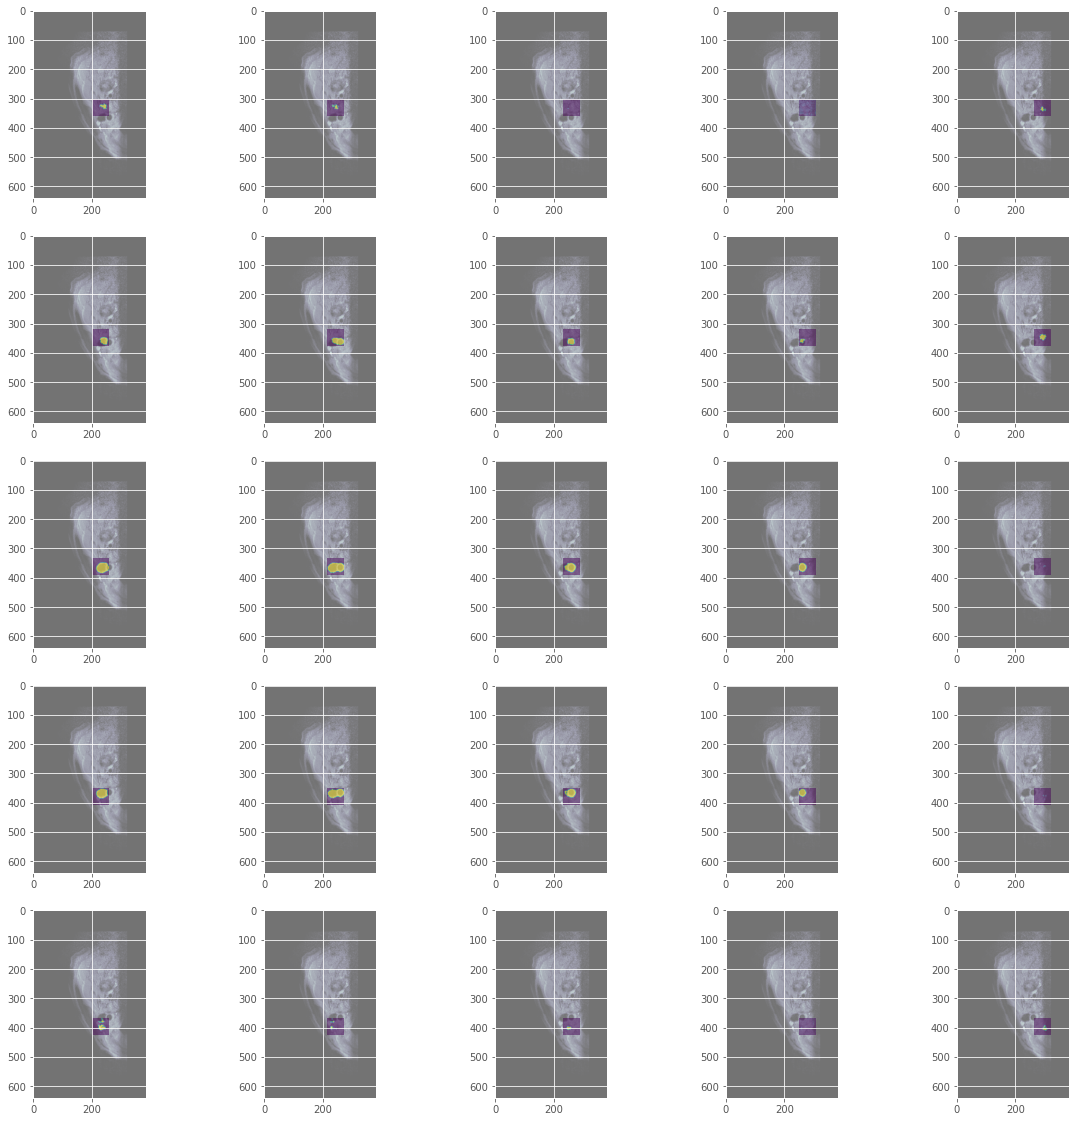

In [116]:
plt.figure(figsize=(20, 20))
for i in range(0, 25):
    plt.subplot(5, 5,i+1)
    plt.imshow(img_padded[..., 0], cmap='bone', alpha=0.5)
    plt.imshow(M[..., i], alpha=0.5)
plt.show()

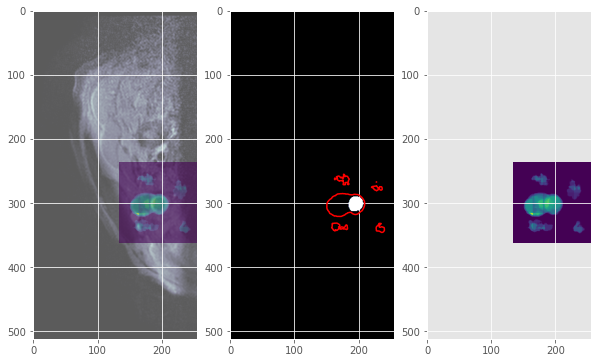

In [123]:
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(X_test[2, ..., 0], cmap='bone', alpha=0.6)
plt.imshow(M_concord, alpha=.6)
plt.subplot(132)
plt.imshow(X_test[0, ..., 1], cmap='bone')
plt.contour(M_concord, colors='r', levels=[0.2])
plt.subplot(133)
plt.imshow(M_concord)
plt.show()

In [143]:
def detect4multipatches_0(img, model):
    
    img_padded = np.zeros((IMG_HEIGHT+128, IMG_WIDTH+128, 2), dtype=np.uint8)
    img_padded[64:-64, 64:-64, :] = img
    
    sm = img_padded[..., 1]
    sm_bin = (sm>0).astype(np.uint8)
    sm_bin_label = label(sm_bin)
    label_weights = []
    for l in range(1, np.max(sm_bin_label)+1):
        mask_label = (sm_bin_label==l).astype(np.uint8)
        weight_label = np.sum(mask_label*sm)
        rec_lw = {'label': l, 'weight': weight_label}
        label_weights.append(rec_lw)
    label_weights = pd.DataFrame(label_weights)
    n_labels = min(len(label_weights), 1)
    labels = []
    if len(label_weights)>0:
        label_weights.sort_values(by='weight', inplace=True, ascending = False)
        labels = np.array(label_weights['label'])[:n_labels]
    contour = np.isin(sm_bin_label, labels).astype(np.uint8)
    contour_pixels = np.where(contour>0)
    x_center = int(np.mean(contour_pixels[0]))
    y_center = int(np.mean(contour_pixels[1]))
    
    img_patch = np.zeros((1, 64, 64, 2))
    img_patch[0, ...] = img_padded[x_center-32:x_center+32, y_center-32:y_center+32, :].copy()
            
    img_patch_pred = model.predict(img_patch, verbose=0)
    pred_padded = np.zeros((img_padded.shape[0], img_padded.shape[1], 1))
    pred_padded[x_center-32:x_center+32, y_center-32:y_center+32, :] = img_patch_pred
            
    return pred_padded[64:-64, 64:-64]

In [149]:
def detect4multipatches_1(img, model):
    
    img_padded = np.zeros((IMG_HEIGHT+128, IMG_WIDTH+128, 2), dtype=np.uint8)
    img_padded[64:-64, 64:-64, :] = img
    
    sm = img_padded[..., 1]
    sm_bin = (sm>0).astype(np.uint8)
    sm_bin_label = label(sm_bin)
    label_weights = []
    for l in range(1, np.max(sm_bin_label)+1):
        mask_label = (sm_bin_label==l).astype(np.uint8)
        weight_label = np.sum(mask_label*sm)
        rec_lw = {'label': l, 'weight': weight_label}
        label_weights.append(rec_lw)
    label_weights = pd.DataFrame(label_weights)
    n_labels = min(len(label_weights), 1)
    labels = []
    if len(label_weights)>0:
        label_weights.sort_values(by='weight', inplace=True, ascending = False)
        labels = np.array(label_weights['label'])[:n_labels]
    contour = np.isin(sm_bin_label, labels).astype(np.uint8)
    contour_pixels = np.where(contour>0)
    x_center = int(np.mean(contour_pixels[0]))
    y_center = int(np.mean(contour_pixels[1]))
    
    step = 32
    x_kernels = []
    y_kernels = []
    n_kernels = 9
    
    M = np.empty((img_padded.shape[0], img_padded.shape[1], n_kernels))
    M[:] = np.NaN
    img_patch = np.zeros((n_kernels, 64, 64, 2))
    
    c = 0
    
    for x in range(x_center-step, x_center+2*step, step):
        for y in range(y_center-step, y_center+2*step, step):
            img_crop = img_padded[x-step:x+step, y-step:y+step, :]
            img_patch[c, ...] = img_crop.copy()
            c += 1
            
    img_patch_pred = model.predict(img_patch, verbose=0)
    
    c = 0
    for x in range (x_center-step, x_center+2*step, step):
        for y in range (y_center-step, y_center+2*step, step):
            M[x-step:x+step, y-step:y+step, c] = img_patch_pred[c, ..., 0]
            c += 1
            
    M_concord = np.nanmean(M, axis = 2)+np.zeros((img_padded.shape[0], img_padded.shape[1]))
    
    del M
            
    return M_concord[64:-64, 64:-64]

In [150]:
def detect4multipatches_2(img, model):
    
    img_padded = np.zeros((IMG_HEIGHT+256, IMG_WIDTH+256, 2), dtype=np.uint8)
    img_padded[128:-128, 128:-128, :] = img
    
    sm = img_padded[..., 1]
    sm_bin = (sm>0).astype(np.uint8)
    sm_bin_label = label(sm_bin)
    label_weights = []
    for l in range(1, np.max(sm_bin_label)+1):
        mask_label = (sm_bin_label==l).astype(np.uint8)
        weight_label = np.sum(mask_label*sm)
        rec_lw = {'label': l, 'weight': weight_label}
        label_weights.append(rec_lw)
    label_weights = pd.DataFrame(label_weights)
    n_labels = min(len(label_weights), 1)
    labels = []
    if len(label_weights)>0:
        label_weights.sort_values(by='weight', inplace=True, ascending = False)
        labels = np.array(label_weights['label'])[:n_labels]
    contour = np.isin(sm_bin_label, labels).astype(np.uint8)
    contour_pixels = np.where(contour>0)
    x_center = int(np.mean(contour_pixels[0]))
    y_center = int(np.mean(contour_pixels[1]))
    
    img_patch = np.zeros((1, 128, 128, 2))
    img_patch[0, ...] = img_padded[x_center-64:x_center+64, y_center-64:y_center+64, :].copy()
            
    img_patch_pred = model.predict(img_patch, verbose=0)
    pred_padded = np.zeros((img_padded.shape[0], img_padded.shape[1], 1))
    pred_padded[x_center-64:x_center+64, y_center-64:y_center+64, :] = img_patch_pred
            
    return pred_padded[128:-128, 128:-128]

## 2. CA probability maps calculation

### 2.1. Test set

Getting patient names from the test set (from training script):

In [152]:
sub_names_test = ['AMC012', 'AMC006', 
                  'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038', 'MUMC093', 'MUMC107', 
                  'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 'MUMC059', 'MUMC080', 
                  'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [153]:
dirname_imgdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/imagesTs1/'
dirname_gtdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/labelsTs1/'
dirname_nnunetdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_results/Ts1/'

In [161]:
dirname_results_test = '../res/nifti_compare/test_plaqunet_0/'

In [164]:
def fill_array(sub_name, dirname_img, dirname_nnunet):
    
    i = 0
    
    filename_img = dirname_img + sub_name + '_0000.nii.gz'
    filename_sm = dirname_nnunet + sub_name + '.npz'
    filename_pkl = dirname_nnunet + sub_name + '.pkl'
    img_nii = nib.load(filename_img)
    img = img_nii.get_fdata().T
    sm_cropped = np.load(filename_sm)['softmax']
    with open(filename_pkl, 'rb') as f:
        p = pickle.load(f)
    crop_box = p['crop_bbox']
    sm = np.zeros(img.shape, dtype=np.float16)
    sm[crop_box[0][0]:crop_box[0][1], crop_box[1][0]:crop_box[1][1], crop_box[2][0]:crop_box[2][1]] = sm_cropped[1, ...]
    
    X = np.zeros((img.shape[0], img.shape[1], img.shape[2], 2), dtype = np.uint8)

    for j in range (0, img.shape[0]):
        img_norm = norm_img(img[j, ...])
        X[i, ..., 0] = img_norm
        X[i, ..., 1] = sm[j, ...]
        i += 1
                
    return X, img_nii.affine

In [171]:
sub_name

'AMC006'

In [173]:
X.shape

(15, 512, 256, 2)

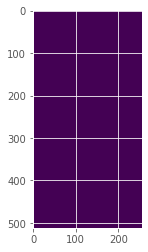

In [192]:
plt.imshow(X[14, ..., 1])

In [170]:
for sub_name in sub_names_test:
    X, affine_nii = fill_array(sub_name, dirname_imgdata_test, dirname_nnunetdata_test)
    pred = np.zeros((X.shape[0], X.shape[1], X.shape[2]), dtype=np.uint8)
    for i in range(0, X.shape[0]):
        pred_slice = detect4multipatches_0(X[i, ...], model_aug)
        pred[i, ...] = (pred_slice[..., 0]>0.5).astype(np.uint8)
    nifti_pred = nib.Nifti1Image(pred.T, affine=affine_nii)
    nib.save(nifti_pred, dirname_results_test + sub_name + '.nii.gz')

C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [ ]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T1w/plaq-u-net_aug/'

for sub_name in sub_names_test:
    
    sub_img_names = glob.glob(ds_dir+sub_name+'*/T1W_*.dcm')
    
    for sub_img_name in sub_img_names:
        
        img = path2array(sub_img_name)
        img_test = img[8:-8,8:-8].copy()
        img_min = np.min(img_test)
        img_max = np.max(img_test)
        img_norm = np.copy((img_test - img_min)/(img_max - img_min)*255).astype(np.uint8)

        vessels_pred_multi_simple = detect4multipatches(img_norm, model_simple)
        vessels_pred_multi_aug = detect4multipatches(img_norm, model_aug)
        
        np.save(results_dir_simple + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_multi_simple)
        np.save(results_dir_aug + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_multi_aug)

In [12]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1wCE/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T1wCE/plaq-u-net_aug/'

for sub_name in sub_names_test:
    
    sub_img_names = glob.glob(ds_dir+sub_name+'*/T1W-contrast_*.dcm')
    
    for sub_img_name in sub_img_names:
        
        img = path2array(sub_img_name)
        img_test = img[8:-8,8:-8].copy()
        img_min = np.min(img_test)
        img_max = np.max(img_test)
        img_norm = np.copy((img_test - img_min)/(img_max - img_min)*255).astype(np.uint8)

        vessels_pred_multi_simple = detect4multipatches(img_norm, model_simple)
        vessels_pred_multi_aug = detect4multipatches(img_norm, model_aug)
        
        np.save(results_dir_simple + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_multi_simple)
        np.save(results_dir_aug + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_multi_aug)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [13]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T2w/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T2w/plaq-u-net_aug/'

for sub_name in sub_names_test:
    
    sub_img_names = glob.glob(ds_dir+sub_name+'*/T2W_*.dcm')
    
    for sub_img_name in sub_img_names:
        
        img = path2array(sub_img_name)
        img_test = img[8:-8,8:-8].copy()
        img_min = np.min(img_test)
        img_max = np.max(img_test)
        img_norm = np.copy((img_test - img_min)/(img_max - img_min)*255).astype(np.uint8)

        vessels_pred_multi_simple = detect4multipatches(img_norm, model_simple)
        vessels_pred_multi_aug = detect4multipatches(img_norm, model_aug)
        
        np.save(results_dir_simple + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_multi_simple)
        np.save(results_dir_aug + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_multi_aug)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


### 2.2 EMC

Patient names from EMC:

In [13]:
sub_names_emc = ['EMC003', 'EMC004', 'EMC005', 'EMC007', 'EMC008', 'EMC009', 'EMC011', 
                 'EMC015', 'EMC018', 'EMC020', 'EMC024', 'EMC027', 'EMC029', 'EMC031', 
                 'EMC032', 'EMC034', 'EMC035', 'EMC036', 'EMC038', 'EMC041', 'EMC042', 
                 'EMC043', 'EMC045', 'EMC046', 'EMC047', 'EMC048', 'EMC049', 'EMC050', 
                 'EMC051', 'EMC052', 'EMC054', 'EMC055', 'EMC056', 'EMC057']

Calculating CA probability maps and saving to the results folder:

In [14]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/plaq-u-net_simple/'
results_dir_aug = '../res/maps/plaq-u-net_aug/'

for sub_name in sub_names_emc:
    
    sub_img_names = glob.glob(ds_dir+sub_name+'*/T1W_*.dcm')
    
    for sub_img_name in sub_img_names:
        
        img = path2array(sub_img_name)
        #img_test = correctBiasField(img)
        img_test = img.copy()
        img_min = np.min(img_test)
        img_max = np.max(img_test)
        img_norm = np.copy((img_test - img_min)/(img_max - img_min)*255).astype(np.uint8)
        
        img_res = cv2.resize(img_norm.copy(), dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        
        vessels_pred_multi_simple = detect4multipatches(img_res, model_simple)
        vessels_pred_multi_aug = detect4multipatches(img_res, model_aug)
        
        vessels_pred_multi_simple_res = cv2.resize(vessels_pred_multi_simple.copy(), 
                                                   dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        vessels_pred_multi_aug_res = cv2.resize(vessels_pred_multi_aug.copy(), 
                                                dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        
        np.save(results_dir_simple + sub_name + '/' + sub_img_name.split(os.sep)[2][-17:-11] + '.npy', 
                vessels_pred_multi_simple_res)
        np.save(results_dir_aug + sub_name + '/' + sub_img_name.split(os.sep)[2][-17:-11] + '.npy', 
                vessels_pred_multi_aug_res)

BFC failed
BFC failed
BFC failed
BFC failed
BFC failed
BFC failed
BFC failed
BFC failed
BFC failed
BFC failed
